# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import time
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
print('CUDA availability:', torch.cuda.is_available())
print('CUDA device:', torch.cuda.get_device_name())


CUDA availability: True
CUDA device: GeForce RTX 2080


## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
'''
data_train = dset.SVHN('/Users/youzhick/Desktop/DL-AI/assignments/assignment1/data', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('/Users/youzhick/Desktop/DL-AI/assignments/assignment1/data', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

data_train = dset.SVHN('E:\\working/DL-AI\\assignments\\assignment1\\data', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('E:\\working/DL-AI\\assignments\\assignment1\\data', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))
#'''
data_train = dset.SVHN('C:\\working\\DL-AI\\data', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('C:\\working\\DL-AI\\data', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))


Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
tensorType = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(tensorType)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(tensorType)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()
            optimizer.zero_grad()
            prediction = model(x)
            loss_value = loss(prediction, y)
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        if not scheduler is None:
            scheduler.step()

        print("Epoch %d/%d. Average loss: %f, Train accuracy: %f, Val accuracy: %f" % ((epoch + 1), num_epochs, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function! What for??
    correct_samples = 0
    total_samples = 0
    for _, (x, y) in enumerate(loader):
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
        prediction = model(x)
        loss_value = loss(prediction, y)

        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]

    result = float(correct_samples) / total_samples
    #raise Exception("Not implemented")
    
    return result

t1 = time.time()
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)
t2 = time.time()
print ('Done in', t2-t1, 's')

Epoch 1/3. Average loss: 1.812669, Train accuracy: 0.416800, Val accuracy: 0.556003
Epoch 2/3. Average loss: 1.449630, Train accuracy: 0.584923, Val accuracy: 0.611835
Epoch 3/3. Average loss: 1.371452, Train accuracy: 0.621029, Val accuracy: 0.628626
Done in 45.66081762313843 s


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [7]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10)
    )
nn_model.type(tensorType)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Epoch 1/5. Average loss: 2.171871, Train accuracy: 0.199160, Val accuracy: 0.237322
Epoch 2/5. Average loss: 2.003156, Train accuracy: 0.281865, Val accuracy: 0.326940
Epoch 3/5. Average loss: 1.813875, Train accuracy: 0.369911, Val accuracy: 0.401474
Epoch 4/5. Average loss: 1.717005, Train accuracy: 0.415231, Val accuracy: 0.423930
Epoch 5/5. Average loss: 1.686008, Train accuracy: 0.430127, Val accuracy: 0.428776


Добавьте слой с Batch Normalization

In [8]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d
nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(100),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(100),
        nn.Linear(100, 10)
    )
nn_model.type(tensorType)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Epoch 1/5. Average loss: 1.909536, Train accuracy: 0.395335, Val accuracy: 0.560167
Epoch 2/5. Average loss: 1.491306, Train accuracy: 0.597550, Val accuracy: 0.632312
Epoch 3/5. Average loss: 1.328184, Train accuracy: 0.651623, Val accuracy: 0.651355
Epoch 4/5. Average loss: 1.228183, Train accuracy: 0.677320, Val accuracy: 0.698314
Epoch 5/5. Average loss: 1.166610, Train accuracy: 0.696209, Val accuracy: 0.696744


Добавьте уменьшение скорости обучения по ходу тренировки.

In [9]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(100),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(100),
        nn.Linear(100, 10)
    )
nn_model.type(tensorType)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

Epoch 1/5. Average loss: 1.897294, Train accuracy: 0.389636, Val accuracy: 0.551293
Epoch 2/5. Average loss: 1.400037, Train accuracy: 0.602839, Val accuracy: 0.661388
Epoch 3/5. Average loss: 1.206517, Train accuracy: 0.664352, Val accuracy: 0.693673
Epoch 4/5. Average loss: 1.128629, Train accuracy: 0.686312, Val accuracy: 0.701795
Epoch 5/5. Average loss: 1.066439, Train accuracy: 0.703631, Val accuracy: 0.714559


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [10]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    predictions = np.array([], dtype=int)
    ground_truth = np.array([], dtype=int)

    sam = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sam)
    for _, (x, y) in enumerate(loader):
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
        ground_truth = np.append(ground_truth, y.cpu())
        pred = model(x)
        _, pred_inds = torch.max(pred, 1)
        pred_inds_np = pred_inds.cpu().numpy()
        predictions = np.append(predictions, pred_inds_np)
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))
print('Done')

Done


## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

![image.png](attachment:image.png)

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

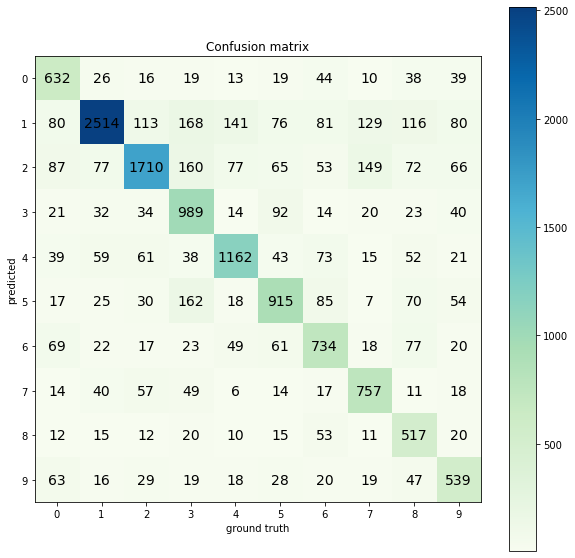

In [11]:
#from sklearn.metrics import confusion_matrix

def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    conf_matr = np.zeros((10,10), np.int)
    
    # TODO: Implement filling the prediction matrix
    assert len(predictions) == len(ground_truth)
    assert predictions.max() <= 9
    assert ground_truth.max() <= 9
    assert predictions.min() >= 0
    assert ground_truth.min() >= 0
    
    for i in range(len(predictions)):
        conf_matr[predictions[i], ground_truth[i]] += 1
    return conf_matr

    #return confusion_matrix(predictions, ground_truth)

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

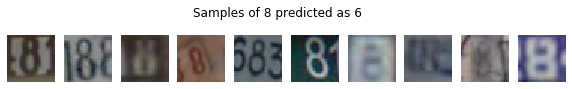

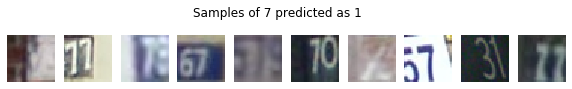

In [12]:
data_train_images = dset.SVHN('C:\\working\\DL-AI\\data', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    inds = []
    for i in range(len(predictions)):
        if predictions[i] == predicted_class and groud_truth[i] == gt_class:
            inds.append(val_indices[i])
    
    visualize_images(inds, data, 'Samples of ' + str(gt_class) + ' predicted as ' + str(predicted_class))

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [13]:
# Experiment here!
hidden_layers_size = 120
train_epochs = 30
nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, hidden_layers_size),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(hidden_layers_size),
        nn.Linear(hidden_layers_size, hidden_layers_size),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(hidden_layers_size),
        nn.Linear(hidden_layers_size, 10)
    )
nn_model.type(tensorType)

#optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1, momentum=0.9, nesterov=True)
#optimizer = optim.Adam(nn_model.parameters(), lr=1e-2)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, train_epochs, scheduler)

Epoch 1/30. Average loss: 1.394812, Train accuracy: 0.535150, Val accuracy: 0.678930
Epoch 2/30. Average loss: 0.983306, Train accuracy: 0.690987, Val accuracy: 0.724865
Epoch 3/30. Average loss: 0.874274, Train accuracy: 0.726035, Val accuracy: 0.749983
Epoch 4/30. Average loss: 0.808662, Train accuracy: 0.747910, Val accuracy: 0.764385
Epoch 5/30. Average loss: 0.751027, Train accuracy: 0.765502, Val accuracy: 0.775305
Epoch 6/30. Average loss: 0.635031, Train accuracy: 0.802495, Val accuracy: 0.808272
Epoch 7/30. Average loss: 0.611242, Train accuracy: 0.809729, Val accuracy: 0.813665
Epoch 8/30. Average loss: 0.593844, Train accuracy: 0.813637, Val accuracy: 0.807658
Epoch 9/30. Average loss: 0.581794, Train accuracy: 0.818756, Val accuracy: 0.815098
Epoch 10/30. Average loss: 0.570084, Train accuracy: 0.820855, Val accuracy: 0.817146
Epoch 11/30. Average loss: 0.508374, Train accuracy: 0.841637, Val accuracy: 0.828271
Epoch 12/30. Average loss: 0.493598, Train accuracy: 0.845937, 

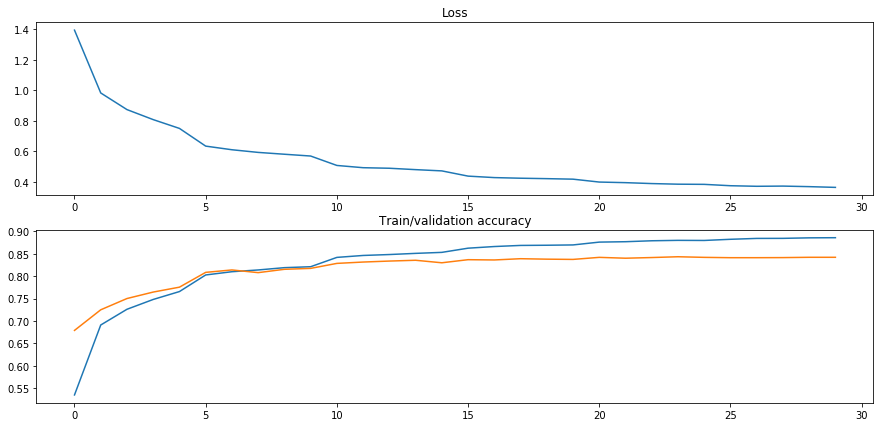

In [14]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

In [15]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8165
